# Prepare Remote Training

## Run the imagemasks notebook

Run `pipeline/imagemasks.ipynb` to generate the image masks.

## start juypter notebook

```
cd Documents/Workspace/datadev/datagpu && pipenv shell
jupyter notebook --no-browser --NotebookApp.allow_origin='*' --port=8080
```

## start ssh tunnel

```
ssh -NfL localhost:8080:localhost:8080 jack@172.23.0.10
```

## transfer data over

```
scp -r /home/jack/Mounts/DiskOne/kona_coffee/imagemasks jack@172.23.0.10:/home/jack/Documents/kona_coffee

scp /home/jack/Documents/Workspace/kona_coffee/pipeline/classified_masks.csv jack@172.23.0.10:/home/jack/Documents
```

## kill all after finish

```
pkill ssh
```

In [1]:
%%sh
python3 --version

Python 3.10.12


In [22]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
sns.set_palette('rainbow')
sns.set_context('talk')

new_basedir = '/home/jack/Documents/kona_coffee/'

df = pd.read_csv('/home/jack/Documents/classified_masks.csv')

df['image'] = df['image'].apply(lambda x: os.path.join(new_basedir, os.path.basename(x)))

df

,image,lifecycle
0,/home/jack/Documents/kona_coffee/100_0045_0_24...,ripening
1,/home/jack/Documents/kona_coffee/100_0060_3200...,ripe
2,/home/jack/Documents/kona_coffee/100_0060_3200...,ripening
3,/home/jack/Documents/kona_coffee/100_0060_3200...,unripe
4,/home/jack/Documents/kona_coffee/100_0060_3200...,unripe
...,...,...
1884,/home/jack/Documents/kona_coffee/100_0018_2000...,unripe
1885,/home/jack/Documents/kona_coffee/100_0028_2000...,unripe
1886,/home/jack/Documents/kona_coffee/100_0034_1200...,unripe
1887,/home/jack/Documents/kona_coffee/100_0034_1200...,ripening


In [23]:
df['lifecycle'].value_counts()

unripe      1157
ripe         423
ripening     309
Name: lifecycle, dtype: int64

In [24]:
# balance the classes by lifecycle
sdf = df.groupby('lifecycle').sample(309, random_state=42)

sdf['lifecycle'].value_counts()

ripe        309
ripening    309
unripe      309
Name: lifecycle, dtype: int64

In [25]:
# sample training data
df_train = sdf.sample(frac=0.8, random_state=42)
df_test = sdf.drop(df_train.index)

In [26]:
# load resnet50v2 model trained on imagenet dataset
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow import keras

resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(224, 224, 3)
)

for layer in resnet.layers:
    layer.trainable = False
    
outputs = resnet.layers[-1].output

outputs = Flatten()(outputs)
outputs = Dense(1024, activation='relu')(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(512, activation='relu')(outputs)
outputs = Dense(3, activation='softmax')(outputs)

model = keras.Model(inputs=resnet.inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'AUC', 'Precision', 'Recall']
)

In [27]:
# image generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess(image):
    image = cv2.resize(image, (224, 224))
    image = preprocess_input(image)
    return image

datagen = ImageDataGenerator(
    preprocessing_function=preprocess,
    zoom_range=[0.5, 1.0],
    rotation_range=90,
    brightness_range=[0.2, 1.0],
    horizontal_flip=True,
    vertical_flip=True,
)

train_gen = datagen.flow_from_dataframe(
    df_train,
    directory=None,
    x_col='image',
    y_col='lifecycle',
    target_size=(224, 224),
    class_mode='categorical',
    validation_split=0.2,
    seed=42,
    batch_size=32,
    shuffle=True
)

test_gen = datagen.flow_from_dataframe(
    df_test,
    directory=None,
    x_col='image',
    y_col='lifecycle',
    target_size=(224, 224),
    class_mode='categorical',
    seed=42,
    batch_size=32,
    shuffle=False
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=False
)

# train model
history = model.fit(
    train_gen,
    validation_data=train_gen,
    callbacks=[early_stopping],
    epochs=300,
    verbose=1
)

Found 471 validated image filenames belonging to 3 classes.
Found 115 validated image filenames belonging to 3 classes.
Epoch 1/300


2023-11-18 18:18:50.183713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


15/15 [==============================] - ETA: 0s - loss: 1.9809 - accuracy: 0.4416 - auc: 0.6084 - precision: 0.4514 - recall: 0.4140

2023-11-18 18:19:01.050788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


15/15 [==============================] - 17s 861ms/step - loss: 1.9809 - accuracy: 0.4416 - auc: 0.6084 - precision: 0.4514 - recall: 0.4140 - val_loss: 2.1438 - val_accuracy: 0.4183 - val_auc: 0.5844 - val_precision: 0.4289 - val_recall: 0.3907
Epoch 2/300
15/15 [==============================] - 9s 628ms/step - loss: 1.6702 - accuracy: 0.4926 - auc: 0.6474 - precision: 0.4932 - recall: 0.4586 - val_loss: 1.3408 - val_accuracy: 0.4756 - val_auc: 0.6383 - val_precision: 0.4751 - val_recall: 0.4055
Epoch 3/300
15/15 [==============================] - 10s 640ms/step - loss: 1.4729 - accuracy: 0.4692 - auc: 0.6553 - precision: 0.4771 - recall: 0.4416 - val_loss: 1.7754 - val_accuracy: 0.4904 - val_auc: 0.6539 - val_precision: 0.4988 - val_recall: 0.4586
Epoch 4/300
15/15 [==============================] - 10s 640ms/step - loss: 1.3806 - accuracy: 0.4841 - auc: 0.6766 - precision: 0.4941 - recall: 0.4416 - val_loss: 1.5330 - val_accuracy: 0.4225 - val_auc: 0.6352 - val_precision: 0.4319 - 

In [28]:
model.save('/home/jack/Documents/classify_masks_model.h5')

10


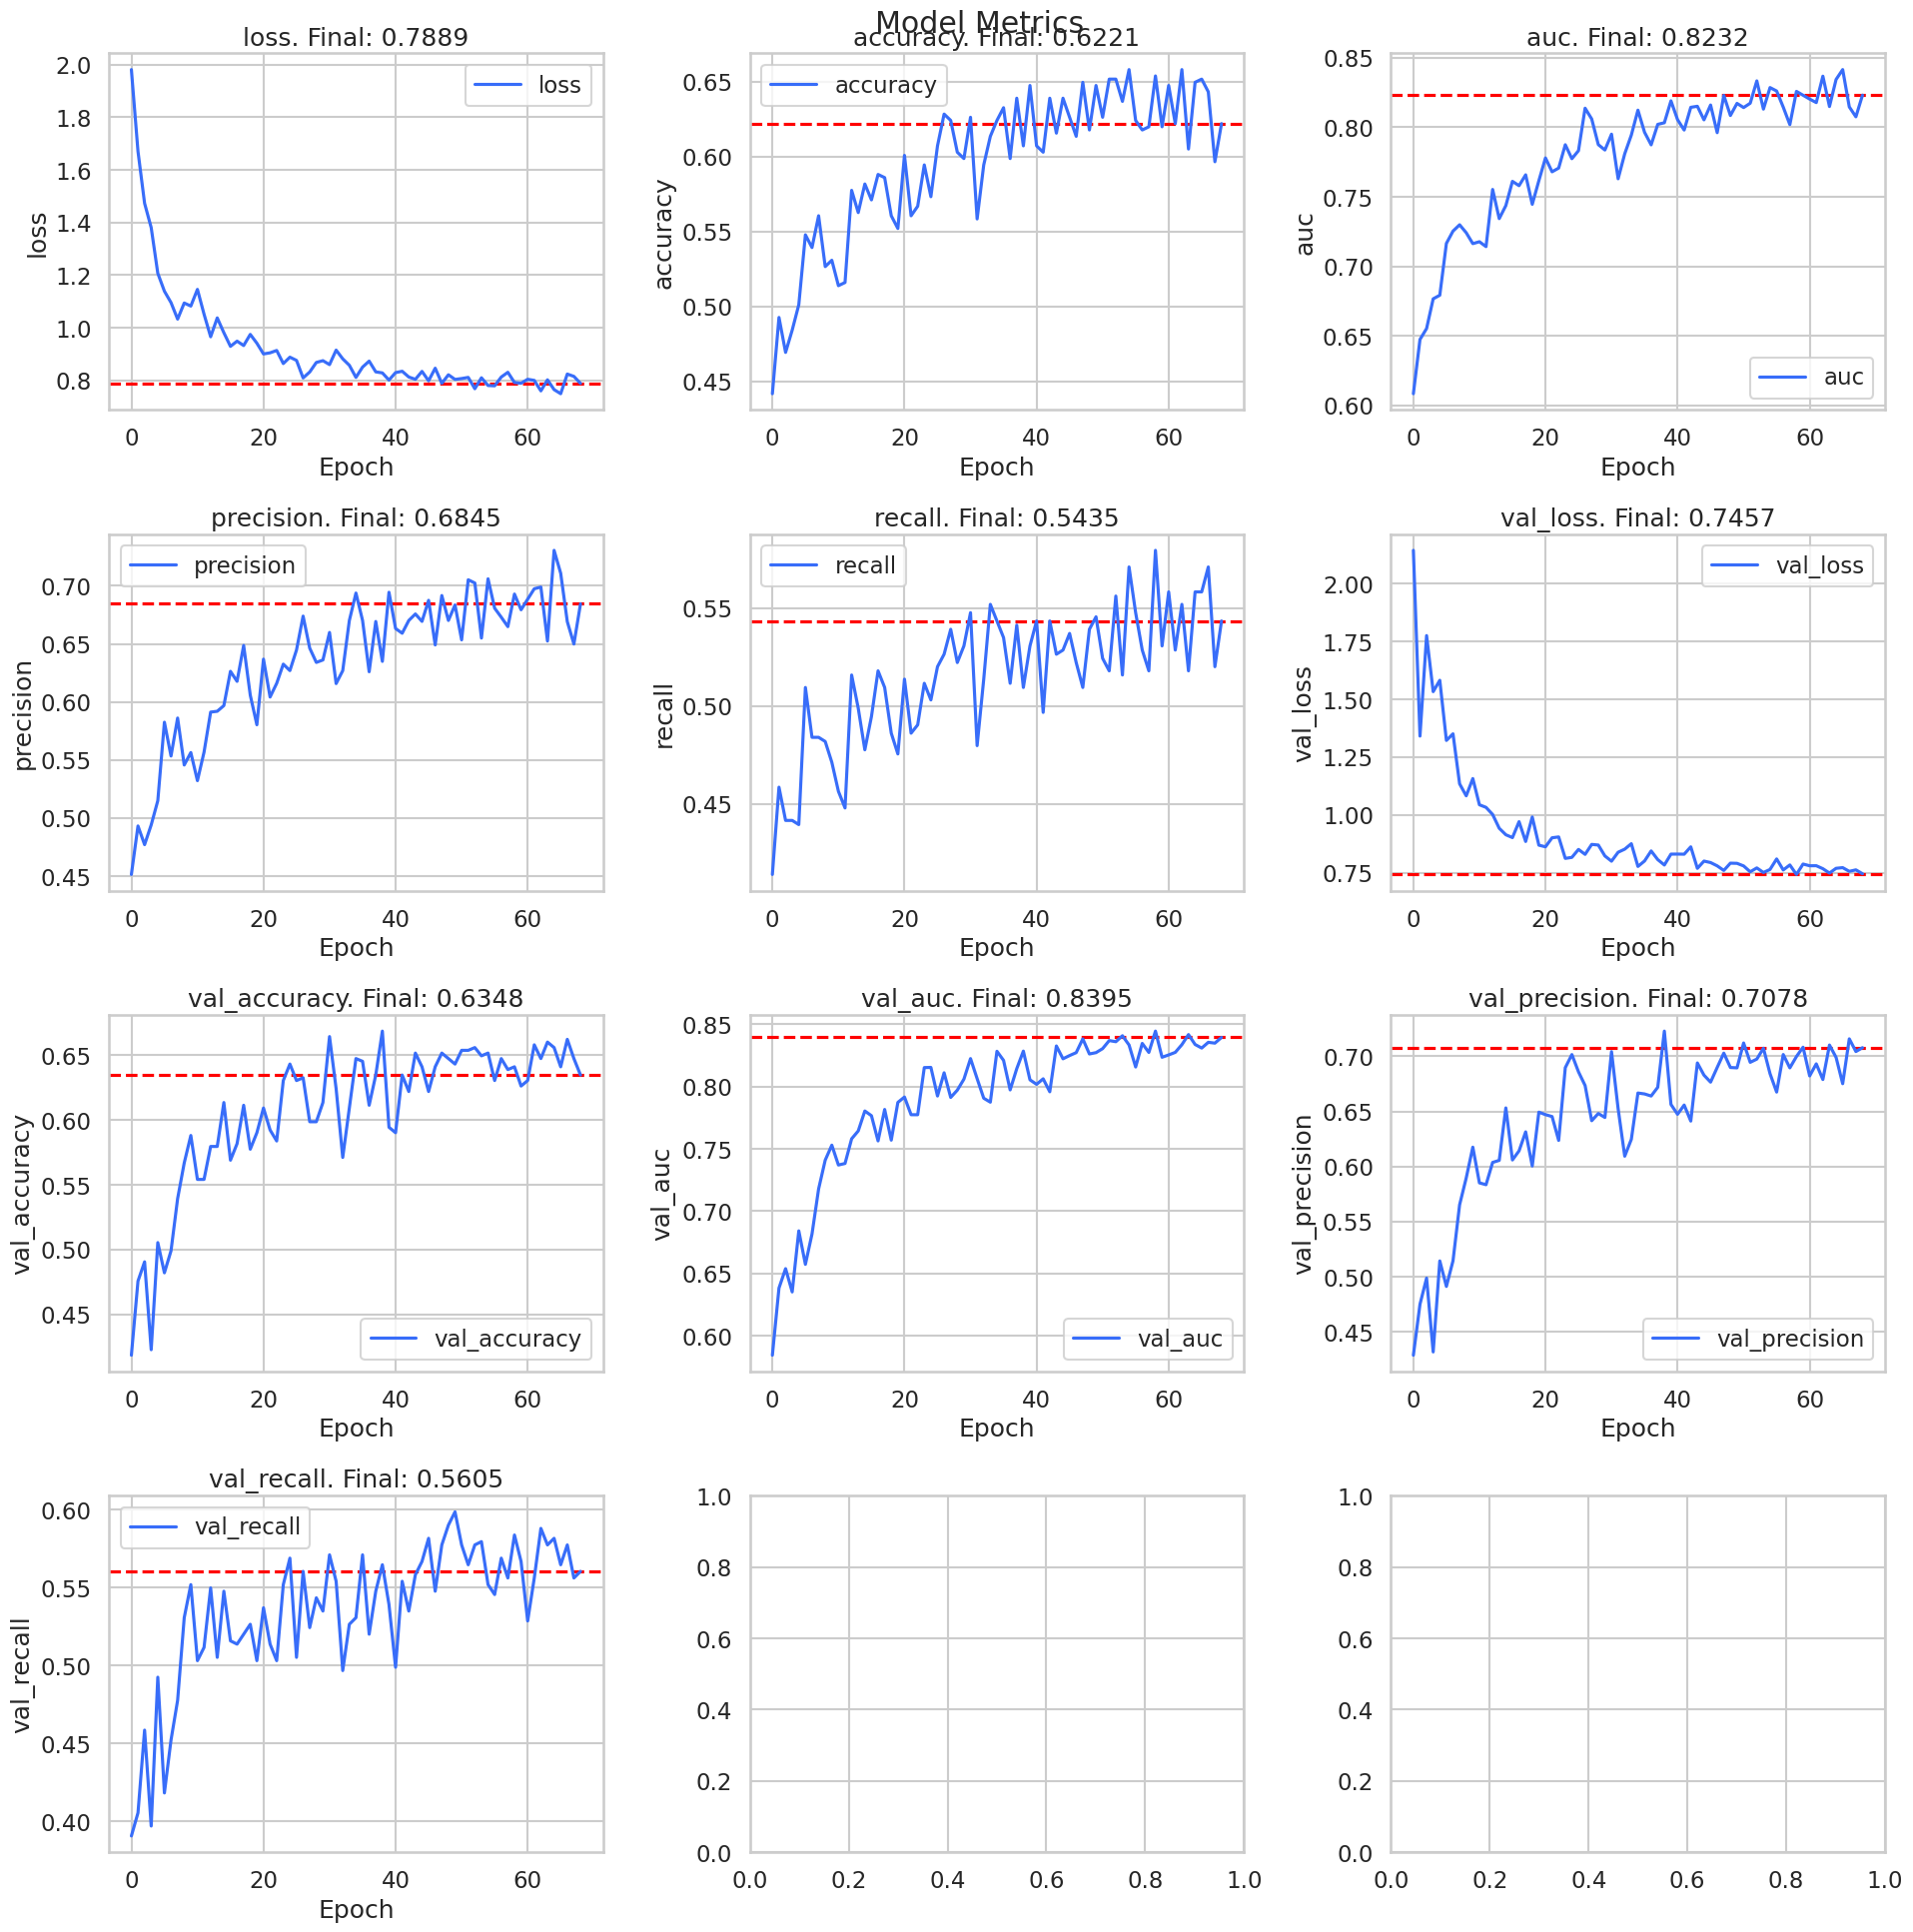

In [29]:
import matplotlib.pyplot as plt

metrics = history.history.keys()

print(len(metrics))

cols = 3
rows = 4

fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
axes = axes.flatten()

# pad the axes
fig.tight_layout(pad=3.0)

fig.suptitle('Model Metrics')

keys = history.history.keys()

for i, key in enumerate(keys):
    
    final_val = history.history[key][-1]
    
    axes[i].axhline(final_val, ls='--', color='r')
    axes[i].plot(history.history[key], label=key)
    axes[i].set_title(f'{key}. Final: {final_val:.4f}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel(key)
    axes[i].legend()


Lower precision and higer recall means that the model has a lot of false positives, but it's also finding a lot of true positives. In other words, it's very sensitive, but it's not very precise.

Higher precision and lower recall means that the model has fewer false positives, but it's also missing a lot of true positives. In other words, it's not very sensitive, but when it does make a prediction, it's usually correct.

In [30]:
test = model.evaluate(test_gen, verbose=1)

print(f'Test loss: {test[0]}')
print(f'Test accuracy: {test[1]}')
print(f'Test AUC: {test[2]}')
print(f'Test Precision: {test[3]}')
print(f'Test Recall: {test[4]}')

2023-11-18 18:30:45.190047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 3s 798ms/step - loss: 1.0872 - accuracy: 0.5391 - auc: 0.7164 - precision: 0.5761 - recall: 0.4609
Test loss: 1.087195634841919
Test accuracy: 0.539130449295044
Test AUC: 0.7163705229759216
Test Precision: 0.5760869383811951
Test Recall: 0.46086955070495605


A test accuracy of 50% on a balanced set of classes means that the model is performing no better than random chance.